In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

In [2]:
def plot(X):
  fig, axis = plt.subplots(1, 10, figsize=(15, 1.5))
  for img, ax in zip(X, axis):
    ax.imshow(img.reshape(28, 28), cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [3]:
(X, _), (X_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Data Augmentation

In [4]:
X_train = np.copy(X)

In [ ]:
'''
for shift in (-2, 2):
  for a in (1, 2, (1, 2)):
    X_train = np.concatenate((X_train, np.roll(X, shift, a)))
    '''

In [ ]:
'''
for shift in ((-2, 2), (2, -2)):
  X_train = np.concatenate((X_train, np.roll(X, shift, (1, 2))))
  '''

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_train = torch.tensor(X_train / 255).to(torch.float32)
X_test = torch.tensor(X_test / 255).to(torch.float32)

# AutoEncoder

In [ ]:
def train(X, model, loss_fn, optim, batch_size):
  for i in range(len(X) // batch_size):
    indices = np.random.choice(range(len(X)), batch_size, replace=False)
    model.train()
    pred = model(X[indices])
    loss = loss_fn(pred, X[indices])
    loss.backward()
    optim.step()
    optim.zero_grad()

In [ ]:
def evaluate(X, model, loss_fn, size, epoch):
  model.eval()
  pred = model(X)
  loss = loss_fn(pred, X).item()
  print(f"Epoch: {epoch} Loss: {round(loss, 4)}")
  fig, axis = plt.subplots(1, size, figsize=(size * 1.5, 1.5))
  for img, ax in zip(pred.detach()[:size], axis):
    ax.imshow(img.reshape(28, 28), cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, X):
    self.encoded = self.encoder(X)
    self.decoded = self.decoder(self.encoded)
    return self.decoded

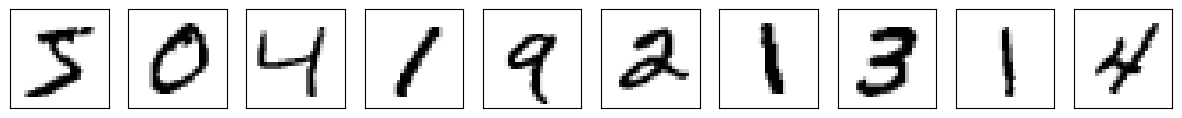

In [ ]:
plot(X_train[:10])

In [ ]:
model = AutoEncoder()
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters())

Epoch: 1 Loss: 0.1287


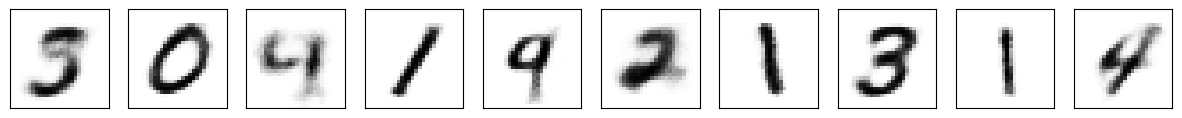

Epoch: 11 Loss: 0.0837


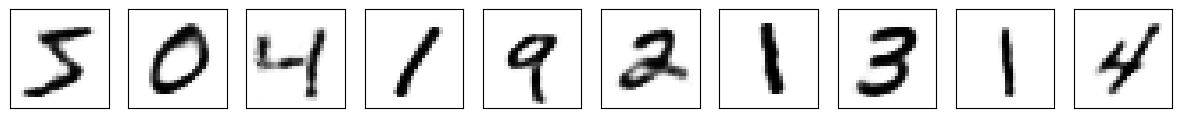

Epoch: 21 Loss: 0.0805


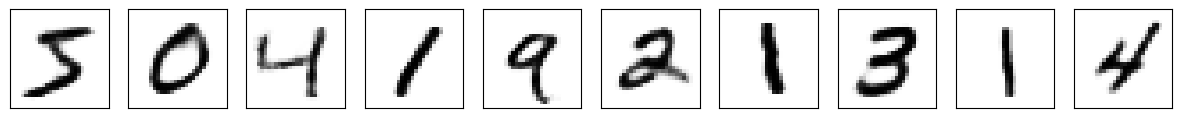

Epoch: 31 Loss: 0.079


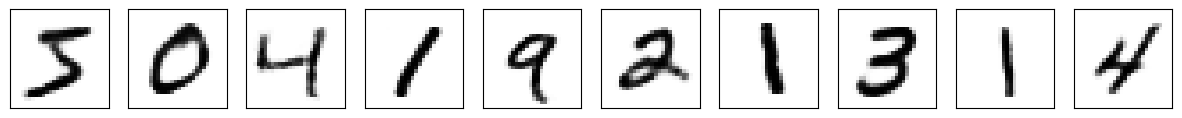

Epoch: 41 Loss: 0.0781


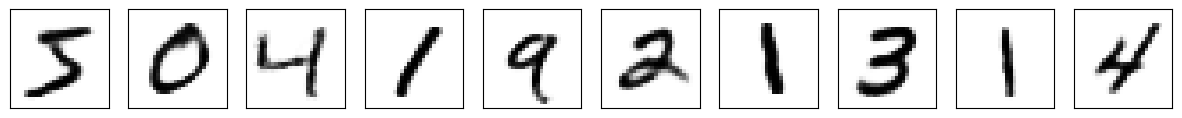

Epoch: 51 Loss: 0.0774


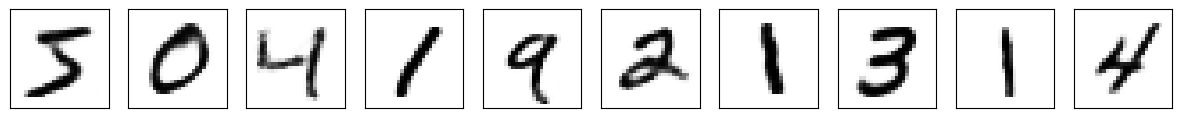

In [ ]:
for i in range(51):
  train(X_train.reshape(60000, 784), model, loss_fn, optim, 100)
  if i % 10 == 0:
    evaluate(X_train.reshape(60000, 784), model, loss_fn, 10, i + 1)

Testing autoencoder on test data

In [ ]:
test_pred = model(X_test[:10].reshape(10, 784))

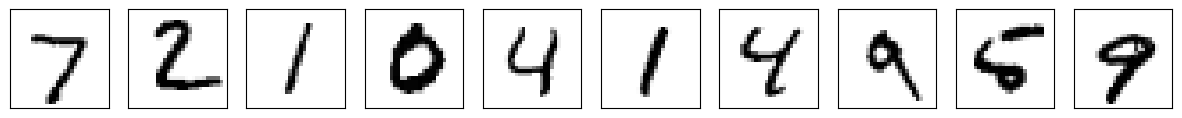

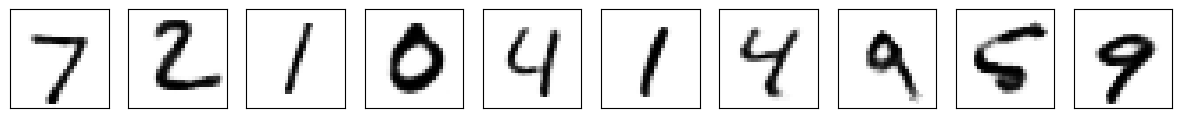

In [ ]:
plot(X_test[:10])
plot(test_pred.detach())

Generating images from random latent variables

<ipython-input-13-a90dcf250944>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  random_latent_variables = torch.tensor([np.random.uniform(0, 16, 32) for i in range(10)]).to(torch.float32)


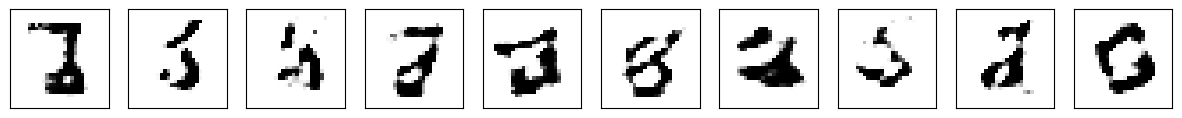

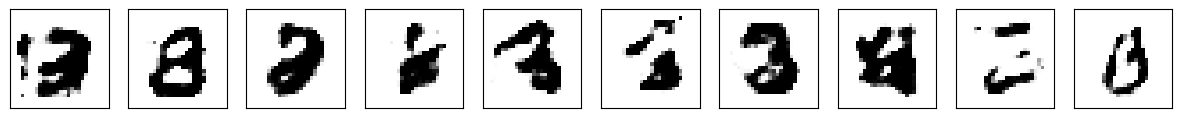

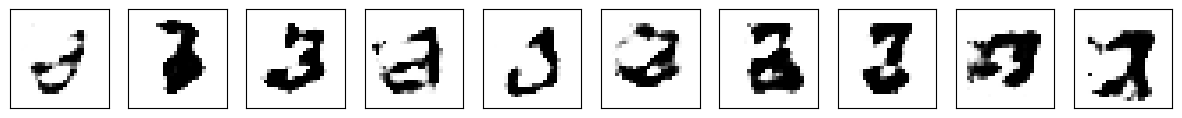

In [ ]:
for i in range(3):
  random_latent_variables = torch.tensor([np.random.uniform(0, 16, 32) for i in range(10)]).to(torch.float32)
  generated_images = model.decoder(random_latent_variables)
  plot(generated_images.detach())

# Variational AutoEncoder

In [8]:
def train(X, model, loss_fn, optim, batch_size):
  for i in range(len(X) // batch_size):
    indices = np.random.choice(range(len(X)), batch_size, replace=False)
    model.train()
    pred, m, s = model(X[indices])
    loss = loss_fn(pred, X[indices], m, s)
    loss.backward()
    optim.step()
    optim.zero_grad()

In [9]:
def evaluate(X, model, loss_fn, size, epoch):
  model.eval()
  pred, m, s = model(X)
  loss = loss_fn(pred, X, m, s).item()
  print(f"Epoch: {epoch} Loss: {round(loss, 4)}")
  fig, axis = plt.subplots(1, size, figsize=(size * 1.5, 1.5))
  for img, ax in zip(pred.detach()[:size], axis):
    ax.imshow(img.reshape(28, 28), cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [10]:
class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()
    self.BCE_Loss = nn.BCELoss(reduction="sum")

  def forward(self, predictions, target, means, log_s):
    kl_loss = -0.5 * torch.sum(1 + log_s - means**2 - torch.exp(log_s))
    return self.BCE_Loss(predictions, target) + kl_loss

In [11]:
class Sample(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, means, log_s):
        return torch.exp(log_s) * torch.rand_like(log_s) + means

In [12]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU()
    )

    self.means = nn.Linear(256, 16)
    self.log_s = nn.Linear(256, 16)
    self.sample = Sample()

    self.decoder = nn.Sequential(
        nn.Linear(16, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid()
    )

  def forward(self, X):
    self.seq = self.seq1(X)
    m = self.means(self.seq)
    ls = self.log_s(self.seq)
    self.sampled = self.sample(m, ls)
    self.decoded = self.decoder(self.sampled)
    return self.decoded, m, ls

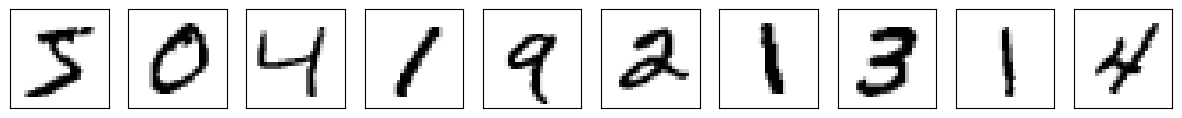

In [ ]:
plot(X_train[:10])

In [13]:
model = VAE()
loss_fn = CustomLoss()
optim = torch.optim.Adam(model.parameters())

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

Epoch: 1 Loss: 6561982.0


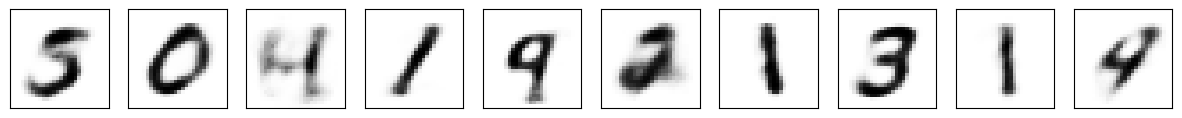

Epoch: 6 Loss: 5402778.5


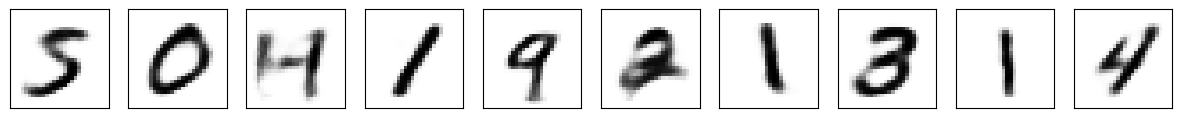

Epoch: 11 Loss: 5181455.0


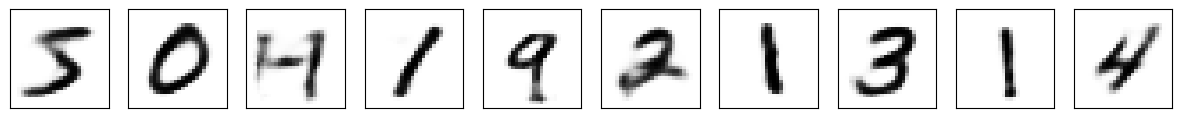

Epoch: 16 Loss: 5089417.5


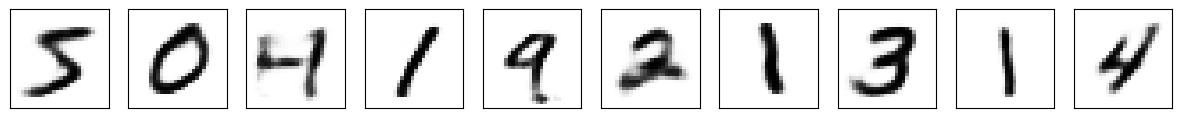

Epoch: 21 Loss: 5020254.5


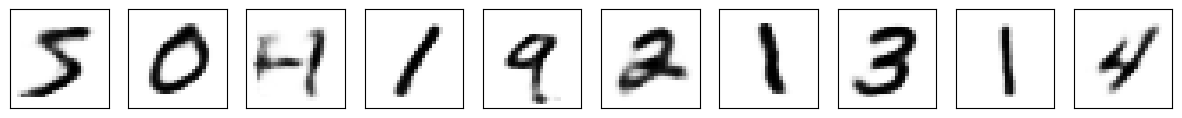

Epoch: 26 Loss: 4981505.5


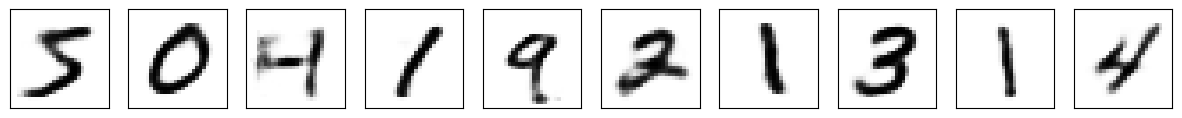

Epoch: 31 Loss: 4948398.0


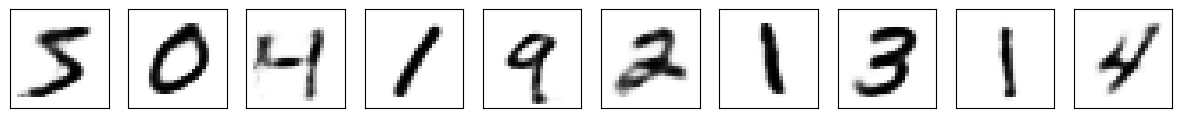

In [14]:
for i in range(31):
  train(X_train.reshape(60000, 784), model, loss_fn, optim, 100)
  if i % 5 == 0:
    evaluate(X_train.reshape(60000, 784), model, loss_fn, 10, i + 1)

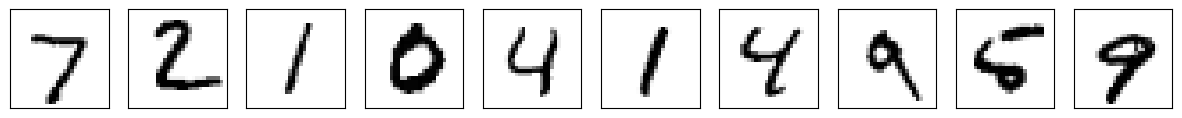

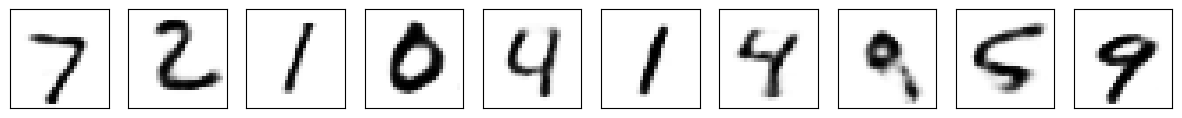

In [15]:
test_pred, m, log_s = model(X_test[:10].reshape(10, 784))
plot(X_test[:10])
plot(test_pred.detach())

In [16]:
pred_means = model.means(model.seq1(X_train.reshape(60000, 784)))
pred_ls = model.log_s(model.seq1(X_train.reshape(60000, 784)))

In [17]:
min_m = torch.min(pred_means, axis=0)[0].detach()
max_m = torch.max(pred_means, axis=0)[0].detach()

min_ls = torch.min(pred_ls, axis=0)[0].detach()
max_ls = torch.max(pred_ls, axis=0)[0].detach()

In [18]:
def generate_samples(minimum, maximum, size):
  samples = []
  for i in range(size):
    samples.append(np.random.uniform(minimum[i], maximum[i], 1)[0])
  return np.array(samples).reshape(size)

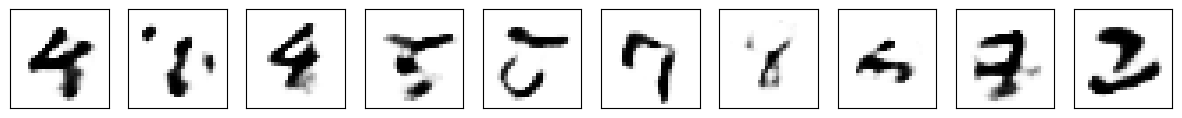

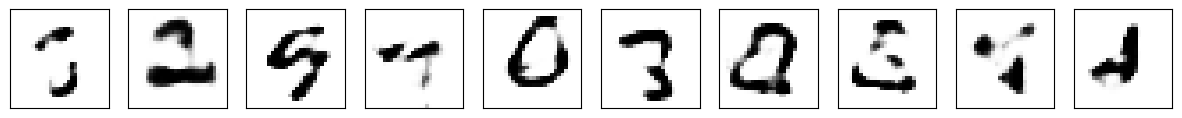

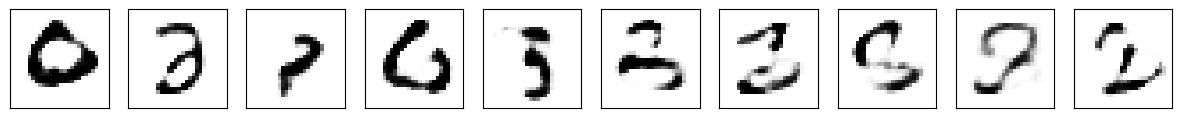

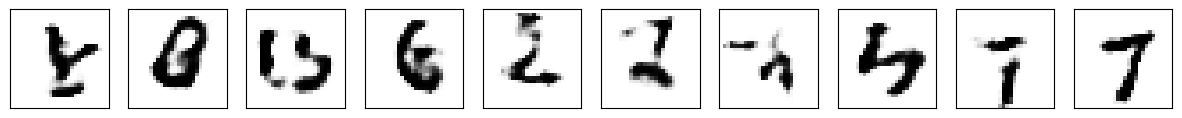

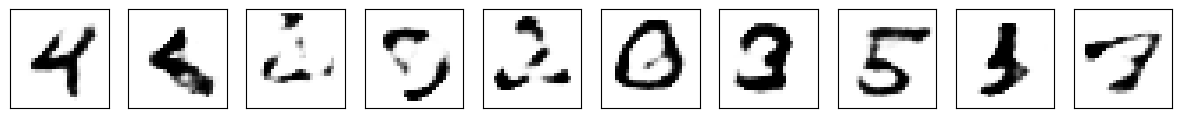

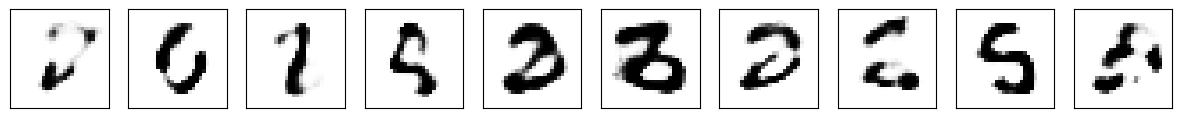

In [21]:
for i in range(6):
  random_latent_means = torch.tensor([generate_samples(min_m, max_m, 16) for i in range(10)]).to(torch.float32)
  random_latent_ls = torch.tensor([generate_samples(min_ls, max_ls, 16) for i in range(10)]).to(torch.float32)
  generated_images = model.decoder(model.sample(random_latent_means, random_latent_ls))
  plot(generated_images.detach())